# Exercise 4: Neural Networks Learning

In [1]:
import numpy as np
import scipy.io as sio
import random
from scipy.optimize import fmin_cg
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import time

## ============
## Neural Network
## ============
### Part 1: Loading and Visualizing Data

In [2]:
data = sio.loadmat('ex4data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
X, y = data['X'], data['y']
y[y == 10] = 0
rand_indices = list(range(len(X)))
random.shuffle(rand_indices)
sel = X[rand_indices[:100]]

In [4]:
def restoreImg(data):
    '''Restore an image for properly displaying.
       Would be called in function displayData'''
    return data.reshape(20, 20).T

def displayData(data):
    '''Display 2D data in a nice grid'''
    plt.figure(figsize=(8, 8))
    if data.shape == (len(data),):
        plt.imshow(restoreImg(data), cmap='gray')
        plt.axis('off')
    else:
        grid_rows = int(np.floor(np.sqrt(len(data))))
        grid_cols = int(np.ceil(len(data) / grid_rows))
        n = 0
        for i in range(grid_rows):
            for j in range(grid_cols):
                ax = plt.subplot2grid((grid_rows, grid_cols), (i, j))
                try:
                    ax.imshow(restoreImg(data[n, :]), cmap='gray')
                except:
                    pass
                plt.axis('off')
                n += 1
    plt.show()

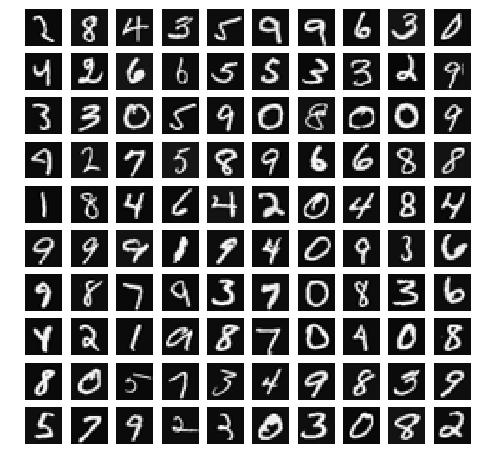

In [5]:
displayData(sel)

### Part 2: Loading Parameters

In [6]:
wghts = sio.loadmat('ex4weights.mat')
wghts.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [7]:
Theta1, Theta2 = wghts['Theta1'], wghts['Theta2']
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

In [8]:
nn_params = np.hstack((Theta1.flatten(), Theta2.flatten()))

### Part 3: Compute Cost (Feedforward)

In [9]:
def sigmoid(z):
    '''Activation function for the neural network'''
    return 1 / (np.e**(-z) + 1)

def nnCostFunction(nn_params, 
                   input_layer_size, 
                   hidden_layer_size, 
                   num_labels, 
                   X, y, lmd=0):
    '''Implements the neural network cost function for a two layer neural 
       network which performs classification'''
    m = X.shape[0]
    # Restore Theta
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape(
        hidden_layer_size, input_layer_size+1)
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape(
        num_labels, hidden_layer_size + 1)
    
    # Feedforward
    X = np.c_[np.ones((m, 1)), X]    # Add bias to input data
    
    z2 = X @ Theta1.T
    a2 = sigmoid(z2)
    a2 = np.c_[np.ones((len(a2), 1)), a2] # Add bias to the 2nd layer to compute z3
    
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)    # Feedforward ends
    
    # Map labels
    y2 = np.zeros((m, num_labels))
    for i in range(m): 
        y2[i, y[i]] = 1
    y2 = np.c_[y2[:, 1:], y2[:, 0]] # Reorder cols due to Octave/Python start number difference.
    
    # Compute cost
    total_cost = 0
    for i in range(m):
        i_cost = -y2[i].reshape(1, num_labels) @ np.log(a3[i]).T - \
                 (1 - y2[i]).reshape(1, num_labels) @ np.log(1 - a3[i]).T
        total_cost += i_cost
      
    J = total_cost/m + ((Theta1[:, 1:]**2).sum() + (Theta2[:, 1:]**2).sum()) * lmd/2/m
    
    # Backpropagation
    delta3 = a3 - y2
    delta2 = delta3 @ Theta2[:, 1:] * a2[:, 1:] * (1 - a2[:, 1:])
    
    Delta2 = delta3.T @ a2
    Delta1 = delta2.T @ X
    
    # Compute Theta
    Theta1_grad = np.zeros_like(Theta1)
    Theta2_grad = np.zeros_like(Theta2)
    Theta1_grad[:, 0] = Delta1[:, 0] / m
    Theta1_grad[:, 1:] = (Delta1[:, 1:] + lmd * Theta1[:, 1:]) / m
    
    Theta2_grad[:, 0] = Delta2[:, 0] / m
    Theta2_grad[:, 1:] = (Delta2[:, 1:] + lmd * Theta2[:, 1:]) / m
    
    grad = np.hstack((Theta1_grad.flatten(), Theta2_grad.flatten()))
    
    return J[0], grad

In [10]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10
lmd = 0

J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)
print('Cost at parameters (loaded from ex4weights):\n\n', J )

Cost at parameters (loaded from ex4weights):

 0.2876291651613188


### Part 4: Implement Regularization

In [11]:
lmd = 1

J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)

print('Cost at parameters (loaded from ex4weights):\n\n', J)

Cost at parameters (loaded from ex4weights):

 0.38376985909092354


### Part 5: Sigmoid Gradient

In [12]:
def sigmoidGradient(z):
    '''Returns the gradient of the sigmoid function, used in fmin_cg'''
    return sigmoid(z) * (1 - sigmoid(z))

In [13]:
g = sigmoidGradient(np.array([-1, -.5, 0, .5, 1]))
print('Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:\n\n', [round(i, 5) for i in g])

Sigmoid gradient evaluated at [-1 -0.5 0 0.5 1]:

 [0.19661, 0.235, 0.25, 0.235, 0.19661]


### Part 6: Initializing Parameters

In [14]:
def randInitializeWeights(L_in, L_out, epsilon_init = .12):
    '''Randomly initialize the weights of a layer with L_in 
       incoming connections and L_out outgoing connections'''
    return np.random.rand(L_out, L_in + 1) * 2 * epsilon_init - epsilon_init

In [15]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.hstack((initial_Theta1.flatten(), initial_Theta2.flatten()))

### Part 7: Implement Backpropagation

In [16]:
def debugInitializeWeights(fan_out, fan_in):
    '''Initialize the weights of a layer with fan_in
       incoming connections and fan_out outgoing connections using a fixed
       strategy, this will help you later in debugging'''
    W = np.zeros((fan_out, fan_in + 1))
    return np.sin(np.arange(1, len(W.flatten()) + 1)).reshape(W.shape, order='F') / 10

def computeNumericalGradient(J, theta):
    '''Computes the gradient using "finite differences" 
       and gives us a numerical estimate of the gradient.'''
    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)
    
    e = 1e-4
    for p in range(len(theta.flatten())):
        perturb[p] = e
        loss1 = J(theta - perturb)[0]
        loss2 = J(theta + perturb)[0]
        numgrad[p] = (loss2 - loss1) / 2 / e
        perturb[p] = 0
    return numgrad
    
def checkNNGradients(lmd=0):
    '''Creates a small neural network to check the backpropagation gradients'''
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = np.mod(range(m), num_labels)  # Don't add 1 due to start number difference
    
    nn_params = np.hstack((Theta1.flatten(), Theta2.flatten()))
    
    def costFunc(p):
        return nnCostFunction(p, input_layer_size, hidden_layer_size, 
                              num_labels, X, y, lmd)
  
    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    for i, j in zip(numgrad, grad):
        if i >= 0:
            print(' {0:.20f}'.format(i), '   ', ' {0:.20f}'.format(j))
        else:
            print('{0:.20f}     {0:.20f}'.format(i, j))
        
    print('\nThe above two columns you get should be very similar.\n',
         '(Left-Your Numerical Gradient, Right-Analytical Gradient)\n\n')
    
    diff = np.max(numgrad - grad) / np.max(numgrad + grad)
    
    print('If your backpropagation implementation is correct, then\n',
         'the relative difference will be small (less than 1e-9).\n',
         '\nRelative Difference: ', diff)
    try:
        np.testing.assert_almost_equal(numgrad, grad)
        print('\n\nTwo results are almost the same. Assertion passed!')
    except:
        print('\n\nTwo results are greatly differenct. Check cost function!')

In [17]:
checkNNGradients()

-0.01028673472847074777     -0.01028673472847074777
-0.00002912751373429501     -0.00002912751373429501
-0.00009325507477342398     -0.00009325507477342398
-0.00002377836372247089     -0.00002377836372247089
 0.01055648611636428313      0.01055648612455001821
 0.00002106304464177811      0.00002106304510898274
 0.00009363263053785431      0.00009363263193927835
 0.00003205702814312872      0.00003205702890415648
-0.01063963682712554260     -0.01063963682712554260
-0.00001353099854384254     -0.00001353099854384254
-0.00009226736263912017     -0.00009226736263912017
-0.00003881452492748849     -0.00003881452492748849
 0.01047526156039424450      0.01047526156700638936
 0.00000552049517210662      0.00000552049441155510
 0.00008901191339560910      0.00008901190884401283
 0.00004497813010928553      0.00004497813077833728
-0.01010633376541392181     -0.01010633376541392181
 0.00000339607009181009      0.00000339607111479734
-0.00008366609627330490     -0.00008366609627330490
-0.000050861

### Part 8:  Implement Regularization

In [18]:
lmd = 3
checkNNGradients(lmd)

-0.01028673472847074777     -0.01028673472847074777
-0.01679405740473427500     -0.01679405740473427500
-0.06009266746653807445     -0.06009266746653807445
-0.01729797736382820972     -0.01729797736382820972
 0.01055648611636428313      0.01055648612455001821
 0.03944025896762681782      0.03944025896823633026
-0.03210074244863747595     -0.03210074244863747595
-0.05765179248440333026     -0.05765179248440333026
-0.01063963682712554260     -0.01063963682712554260
 0.05934796379891693618      0.05934796380132684179
 0.02511775484714817708      0.02511775484700494096
-0.04509804933272576477     -0.04509804933272576477
 0.01047526156039424450      0.01047526156700638936
 0.02473262960878130912      0.02473262960891694714
 0.05952545325538238785      0.05952545325053624353
 0.00903761070869535388      0.00903761071055547878
-0.01010633376541392181     -0.01010633376541392181
-0.03263787058171985223     -0.03263787058171985223
 0.03893360431161951851      0.03893360431251506604
 0.054725853

In [19]:
debug_J = nnCostFunction(nn_params, input_layer_size, hidden_layer_size,
                        num_labels, X, y, lmd)[0]
print('\nCost at (fixed) debugging parameters (w/ lambda =', lmd, '): ', debug_J)


Cost at (fixed) debugging parameters (w/ lambda = 3 ):  0.576051246950133


### Part 8: Training NN

In [20]:
def costFunction(p):
    '''To be called by optimization function fmin_cg for model training'''
    return nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)[0]
def gradientFunction(p):
    '''To be called by optimization function fmin_cg for model training'''
    return nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, lmd)[1]

In [21]:
lmd = .5

print('Optimization started @', time.ctime(), '\n')
trained_nn_params = fmin_cg(costFunction, initial_nn_params, gradientFunction, maxiter=400)
print('\nOptimization Ended @', time.ctime())

Optimization started @ Sun Jul 28 13:30:18 2019 

         Current function value: 0.209587
         Iterations: 400
         Function evaluations: 1014
         Gradient evaluations: 1014

Optimization Ended @ Sun Jul 28 13:36:41 2019


In [22]:
Theta1 = trained_nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape(
    hidden_layer_size, input_layer_size+1)
Theta2 = trained_nn_params[hidden_layer_size * (input_layer_size + 1):].reshape(
    num_labels, hidden_layer_size + 1)

### Part 9: Visulaze Weights

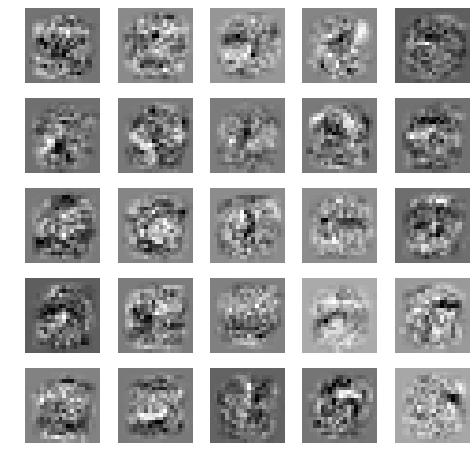

In [23]:
displayData(Theta1[:, 1:])

### Part 10: Implement Predict

In [24]:
def predict(Theta1, Theta2, X): 
    '''Predict the label of an input given a trained neural network'''
    m = X.shape[0]
    h1 = sigmoid(np.c_[np.ones((m, 1)), X] @ Theta1.T)
    h2 = sigmoid(np.c_[np.ones((m, 1)), h1] @ Theta2.T)
    return h2.argmax(axis=1) + 1  # Balance the start number difference between Octave & Python

In [25]:
pred = predict(Theta1, Theta2, X)
y[y == 0] = 10
print('Training Set Accuracy: \n', np.mean(pred == y.reshape(-1)) * 100)

Training Set Accuracy: 
 99.94


**_Try smaller lambda resulting overfitting_**

In [26]:
lmd = .3
y[y == 10] =0    # Need to reset y labels for training

print('Optimization started @', time.ctime(), '\n')
trained_nn_params = fmin_cg(costFunction, initial_nn_params, gradientFunction, maxiter=1000)
print('\nOptimization ended @', time.ctime())

Optimization started @ Sun Jul 28 13:36:43 2019 

         Current function value: 0.140202
         Iterations: 1000
         Function evaluations: 2836
         Gradient evaluations: 2836

Optimization ended @ Sun Jul 28 13:54:45 2019


In [27]:
Theta1 = trained_nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape(
    hidden_layer_size, input_layer_size+1)
Theta2 = trained_nn_params[hidden_layer_size * (input_layer_size + 1):].reshape(
    num_labels, hidden_layer_size + 1)

pred = predict(Theta1, Theta2, X)
y[y == 0] = 10
print('Training Set Accuracy: \n', np.mean(pred == y.reshape(-1)) * 100)

Training Set Accuracy: 
 100.0
